# Tutorial: Minimum Eigen Optimizer

For original tutorial refer to https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html

In [ ]:
! pip install qiskit_optimization

In [23]:
from typing import List, Tuple

import numpy as np

from qiskit.utils import algorithm_globals
from qiskit.primitives import BackendSampler
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.visualization import plot_histogram
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram

from qiskit_braket_provider import AWSBraketProvider

### Converting a QUBO to an Operator

In [8]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(
    linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2}
)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [9]:
op, offset = qubo.to_ising()
print(f"offset: {offset}")
print("operator:")
print(op)

offset: 1.5
operator:
-0.5 * IIZ
+ 0.25 * IZI
- 1.75 * ZII
+ 0.25 * IZZ
- 0.25 * ZIZ
+ 0.5 * ZZI


In [10]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x0 - 2 x1 + 3 x2 + [ 2 x0*x1 - 2 x0*x2 + 4 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



### Solving a QUBO with the MinimumEigenOptimizer


In [24]:
algorithm_globals.random_seed = 10598

sampler = BackendSampler(
    backend=AWSBraketProvider().backends(local=True)[0],
    options={ 'seed_simulator': algorithm_globals.random_seed,
    "seed_transpiler":algorithm_globals.random_seed},
    skip_transpilation=False
)
qaoa_mes = QAOA(sampler=sampler, optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()


In [25]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(
    exact_mes
)  # using the exact classical numpy minimum eigen solver

In [26]:
exact_result = exact.solve(qubo)
print(exact_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


In [27]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


### Analysis of Samples

In [28]:
print("variable order:", [var.name for var in qaoa_result.variables])
for smpl in qaoa_result.samples:
    print(smpl)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.4013671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.162109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.2216796875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.1376953125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.0146484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.0322265625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.0283203125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.001953125, status=<OptimizationResultStatus.SUCCESS: 0>)


In [29]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (
        OptimizationResultStatus.SUCCESS,
    ),
):
    """Returns filtered samples."""
    res = []
    for sample in samples:
        if sample.status in allowed_status and sample.probability > threshold:
            res.append(sample)

    return res

In [30]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.4013671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.162109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.2216796875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.1376953125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.0146484375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.0322265625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.0283203125, status=<OptimizationResultStatus.SUCCESS: 0>)


In [31]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [32]:
np.mean(fvals)

1.5

In [33]:
np.std(fvals)

1.9364916731037085

In [34]:
samples_for_plot = {
    " ".join(
        f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(smpl.x)
    ): smpl.probability
    for smpl in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.4013671875,
 'x=1 y=1 z=0': 0.162109375,
 'x=0 y=0 z=0': 0.2216796875,
 'x=1 y=0 z=0': 0.1376953125,
 'x=0 y=1 z=1': 0.0146484375,
 'x=1 y=0 z=1': 0.0322265625,
 'x=0 y=0 z=1': 0.0283203125}

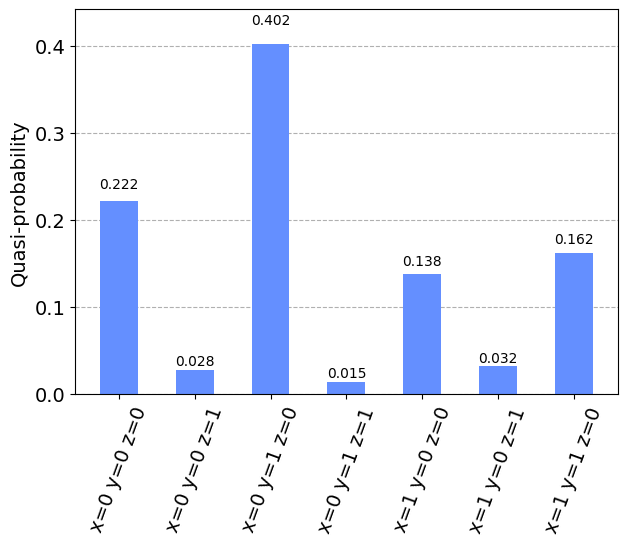

In [35]:
plot_histogram(samples_for_plot)

### RecursiveMinimumEigenOptimizer

In [36]:
rqaoa = RecursiveMinimumEigenOptimizer(
    qaoa, min_num_vars=1, min_num_vars_optimizer=exact
)

In [37]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


In [38]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)

In [39]:
samples_for_plot = {
    " ".join(
        f"{rqaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)
    ): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

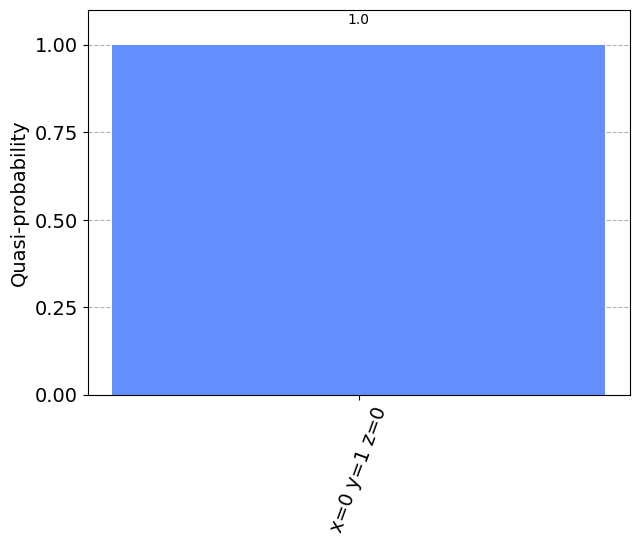

In [40]:
plot_histogram(samples_for_plot)